In [2]:
# set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
device = torch.device('mps')

In [4]:
df = pd.read_csv('Datasets/fashion-mnist_train.csv')

In [5]:
#df = data.iloc[:6000,:]

In [6]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


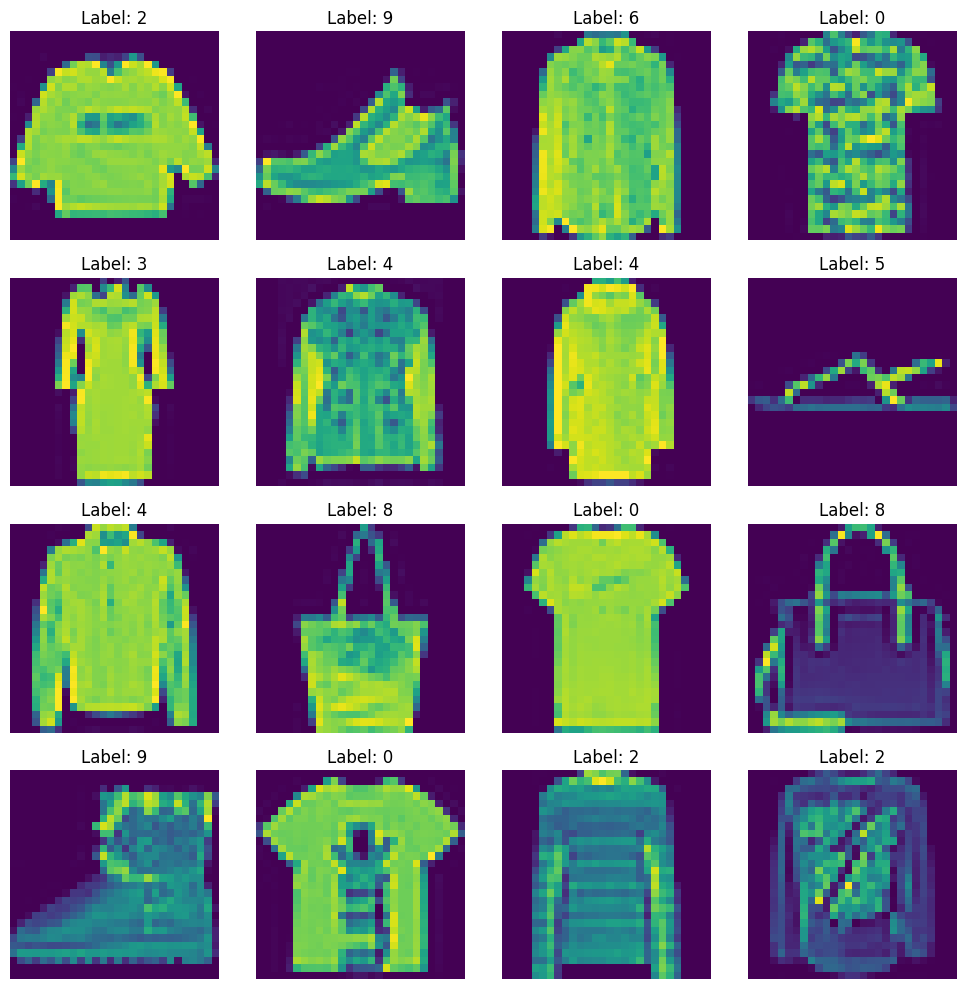

In [7]:
# create a 4x4 grid of images
fig, axes = plt.subplots(4,4, figsize=(10,10))

# plot the first 16 
images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label: {df.iloc[i,0]}')

plt.tight_layout()
plt.show()

In [8]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [1]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined

In [10]:
# scaling the features (pixel value ranges from 0-255) so we divide by every pixel by 255 so that it can range between 0 to 1
X_train = X_train/255.0
X_test = X_test/255.0

In [22]:
# create CustomDataset class
class CustomDataset(Dataset):

    def __init__(self, features, labels):

        # device=device --- moving data to mps
        self.features = torch.tensor(features, dtype=torch.float32, device=device)
        self.labels = torch.tensor(labels, dtype=torch.long, device=device)

    def __len__(self):

        return len(self.features)

    def __getitem__(self, index):

        return self.features[index], self.labels[index]

In [12]:
# create train_dataset object
train_dataset = CustomDataset(X_train, y_train)


In [13]:
# create test_dataset object
test_dataset = CustomDataset(X_test, y_test)

In [14]:
# create train and test loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [23]:
# define the NN class
class MySimpleNN(nn.Module):

    def __init__(self, num_features):

        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),            # applying batch normalization
            nn.ReLU(),
            nn.Dropout(p=0.3),              # applying Dropout
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),            # applying batch normalization,
            nn.ReLU(), 
            nn.Dropout(p=0.3),              # applying Dropout
            nn.Linear(64, 10)
        )
        
    def forward(self, X):

        return self.model(X)
        

In [16]:
# set learning rate and epochs
learning_rate = 0.1
epochs = 100

In [24]:
# instatiate the model
model = MySimpleNN(X_train.shape[1])

# move data to mps
model = model.to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)     # weight_decay - applying l2 regularization

In [25]:
# training loop 

for epoch in range(epochs):

    total_epoch_loss = 0 
    for batch_features, batch_labels in train_loader:

        # move data to mps
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # forward pass
        outputs = model(batch_features)
        
        # calulate loss
        loss = criterion(outputs, batch_labels)
        # clear gradients
        optimizer.zero_grad()
        
        # back pass
        loss.backward()

        # update grads
        optimizer.step()

        total_epoch_loss  = total_epoch_loss + loss.item()

    avg_loss = total_epoch_loss / len(train_loader)
    print(f'Epoch: {epoch + 1}, Loss: {avg_loss}')
        

Epoch: 1, Loss: 0.8554416057268779
Epoch: 2, Loss: 0.5544012385209401
Epoch: 3, Loss: 0.49196438503265383
Epoch: 4, Loss: 0.46135629020134605
Epoch: 5, Loss: 0.4367379339734713
Epoch: 6, Loss: 0.4245514705181122
Epoch: 7, Loss: 0.4091501637299855
Epoch: 8, Loss: 0.3975785768230756
Epoch: 9, Loss: 0.38834673595428465
Epoch: 10, Loss: 0.3808819827735424
Epoch: 11, Loss: 0.3723506176273028
Epoch: 12, Loss: 0.3634170246521632
Epoch: 13, Loss: 0.35958541466792426
Epoch: 14, Loss: 0.35285949023564656
Epoch: 15, Loss: 0.3489791407883167
Epoch: 16, Loss: 0.34327023223042485
Epoch: 17, Loss: 0.3404649235109488
Epoch: 18, Loss: 0.3355526732603709
Epoch: 19, Loss: 0.33218095802267394
Epoch: 20, Loss: 0.331137926697731
Epoch: 21, Loss: 0.3258252052565416
Epoch: 22, Loss: 0.31776319961746535
Epoch: 23, Loss: 0.3169943898121516
Epoch: 24, Loss: 0.3155410275260607
Epoch: 25, Loss: 0.31258064568042754
Epoch: 26, Loss: 0.3104117924173673
Epoch: 27, Loss: 0.3091869548410177
Epoch: 28, Loss: 0.3024889931

In [ ]:
# same above code but with Autocast, GradScalar

scaler = GradScaler()

for epoch in range(epochs):
    
    model.train()
    
    total_loss = 0

    for batch_features, batch_labels in train_loader:

        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        
        with autocast(dtype=torch.float16):
            
            pred = model(batch_features)
            loss = criterion(pred, batch_labels)

        scaler.scale(loss).backward()

        scaler.step(optimizer)

        scaler.update()

        total_loss = total_loss + loss.item()

    avg_loss = total_loss / len(train_loader)
    
    print(f'Epoch: {epoch + 1}, Loss: {avg_loss}')

In [26]:
# set model to eval mode
model.eval()

MySimpleNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [27]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

    for batch_features, batch_labels in test_loader:
        
        # move data to mps
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)


        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)

        total = total + batch_labels.shape[0]

        correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)
        

0.8925833333333333


In [28]:
# lets evaluate our training dataset
# evaluation code
total = 0
correct = 0

with torch.no_grad():

    for batch_features, batch_labels in train_loader:
        
        # move data to mps
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)


        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)

        total = total + batch_labels.shape[0]

        correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)
        

0.9425625


In [29]:
# our training dataset is giving around 98% of accuracy and test dataset is giving 89% mean our model is overfitting


### Overfitting
##### How to reduce overfitting -
- Adding more data
- Reducing the complexity of NN architecture
    - Reduce hidden layers
- Regularization
    - Adding penalty term in loss (l2)
- Dropouts
- Data augmentation
- Batch Normalization
- Early Stopping